# Importing Libs!


In [5]:
import pandas as pd
import string
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem.snowball import GermanStemmer
import re
from sklearn import preprocessing
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import spacy
from sklearn.model_selection import StratifiedKFold
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import pickle

# uploading data

In [6]:
train = pd.read_csv("C://Users//Hamza GH//Pictures//10kGNAD-master//train.csv", encoding='utf-8', header=None , sep='delimiter',engine='python')

In [7]:
test = pd.read_csv("C://Users//Hamza GH//Pictures//10kGNAD-master//test.csv", encoding='utf-8', header=None , sep='delimiter',engine='python')

In [8]:
test.head()

,0
0,Wirtschaft;'Die Gewerkschaft GPA-djp lanciert ...
1,Sport;Franzosen verteidigen 2:1-Führung – Krit...
2,Web;'Neues Video von Designern macht im Netz d...
3,Sport;23-jähriger Brasilianer muss vier Spiele...
4,International;Aufständische verwendeten Chemik...


In [9]:
train.head()

,0
0,Sport;21-Jähriger fällt wohl bis Saisonende au...
1,"Kultur;'Erfundene Bilder zu Filmen, die als ve..."
2,Web;Der frischgekürte CEO Sundar Pichai setzt ...
3,"Wirtschaft;Putin: ""Einigung, dass wir Menge au..."
4,Inland;Estland sieht den künftigen österreichi...


In [10]:
df = train.copy()
df_test = test.copy()

# Creating class & text columns

In [11]:
df['class'] = 'nan'
df['text'] = 'nan'
df_test['class'] = 'nan'
df_test['text'] = 'nan'

In [12]:
for j,i in enumerate(df[0]):
    df['class'][j]= i.split(';')[0]
    df['text'][j]=i.split(';')[1]
for j,i in enumerate(df_test[0]):
    df_test['class'][j]= i.split(';')[0]
    df_test['text'][j]=i.split(';')[1]

In [13]:
df = df.drop(0,axis=1)
df_test = df_test.drop(0,axis=1)


In [14]:
df_test.head()

,class,text
0,Wirtschaft,"'Die Gewerkschaft GPA-djp lanciert den ""All-in..."
1,Sport,Franzosen verteidigen 2:1-Führung – Kritische ...
2,Web,'Neues Video von Designern macht im Netz die R...
3,Sport,23-jähriger Brasilianer muss vier Spiele pausi...
4,International,Aufständische verwendeten Chemikalie bei Gefec...


# Concat train and test data


In [29]:
df = df.append(df_test)
len(df)

11301

In [30]:

df.groupby('class').count()


,text
class,
Etat,735
Inland,1117
International,1662
Kultur,593
Panorama,1846
Sport,1321
Web,1845
Wirtschaft,1552
Wissenschaft,630


# Visualize the number of examples per class

<AxesSubplot:ylabel='class'>

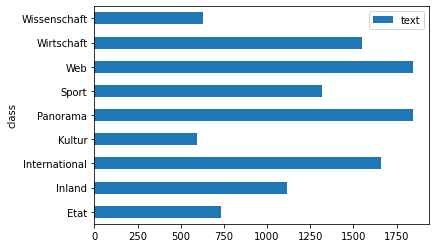

In [31]:
df.groupby('class').count().plot(kind='barh')

As we can see , our data contains nine different imbalanced classes 

# Data preparation 

In [32]:
df1 = df.copy()

# Creating cleaning functions

In [33]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [34]:
STOPWORDS = set(stopwords.words('german'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


In [35]:
cnt = Counter()
for text in df1["text"].values:
    for word in text.split():
        cnt[word] += 1
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])


In [36]:
stemmer = GermanStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

In [37]:
#python -m spacy download "de_core_news_md"

In [38]:
nlp = spacy.load('C://Users//Hamza GH//anaconda3//Lib//site-packages//de_core_news_md//de_core_news_md-2.3.0')
def lemmatizer(text):
     doc = nlp(text)
     return ' '.join([x.lemma_ for x in doc]) 

In [39]:
def preprocessing(df):
    df["text"] = df["text"].str.lower()
    df["text"] = df["text"].apply(lambda text: remove_punctuation(text))
    df["text"] = df["text"].apply(lambda text: remove_stopwords(text))
    df["text"] = df["text"].apply(lambda text: remove_freqwords(text))
    df["text"] = df["text"].apply(lambda text: stem_words(text))
    df["text"] = df["text"].apply(lambda text: lemmatizer(text))
    df["text"] = df["text"].apply(lambda text: re.sub("\d+"," ",text))
    return df

In [40]:
df1 = preprocessing(df1)

In [41]:
df1 = df1.reset_index(drop=True)

# Word cloud for each class

We will see the most frequent words to discover the vocab of each category of our data 

In [90]:
df_sport = df1[df1['class']== 'Sport']
corpus_sport = " ".join(i for i in df_sport['text'])

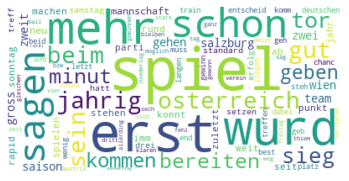

In [252]:
wordcloud = WordCloud(max_font_size=70, max_words=100, background_color="white").generate(corpus_sport)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [92]:
df_web = df1[df1['class']== 'Web']
corpus_web = " ".join(i for i in df_sport['text'])

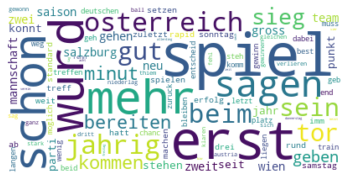

In [253]:
wordcloud = WordCloud(max_font_size=70, max_words=100, background_color="white").generate(corpus_web)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Building the models

At this stage of work , we'll train and test three models to deal with our classification problem, RandomForestClassifier , LinearSVC and xgboost_classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df1['text'], df1['class'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
features = tfidf.fit_transform(df1.text).toarray()
labels = df1.class
features.shape

C:\Users\Hamza GH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:03:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:03:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Hamza GH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:09:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:09:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Hamza GH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:15:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:15:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Hamza GH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:21:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:21:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Hamza GH\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:27:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:27:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


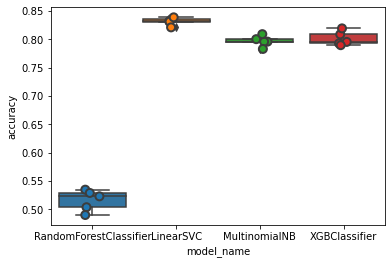

In [103]:
labels = df1['class']
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    xgb.XGBClassifier(learning_rate =0.07,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0.1,
                    num_class = 9,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softprob',
                    seed=27,
                   scale_pos_weight=100),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

# Evaluation using accuracy score

In [104]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.831431
MultinomialNB             0.796567
RandomForestClassifier    0.515883
XGBClassifier             0.800903
Name: accuracy, dtype: float64

LinearSVC and XGBClassifier perform better than the other two classifiers, with LinearSVC having a slight advantage with a median accuracy of around 83%.

# Evaluation of LinearSVC

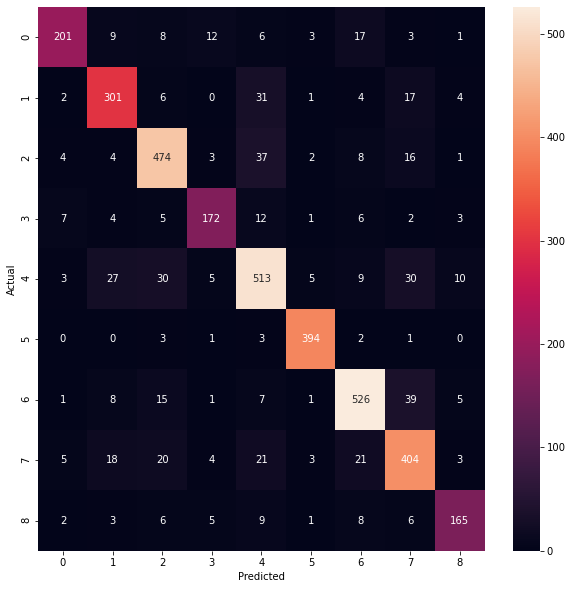

In [121]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Final train of the chosen model (linearSVC)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(df1['text'], df1['class'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = LinearSVC().fit(X_train_tfidf, y_train)

# Save model

In [123]:
# Save the trained model as a pickle string.
saved_model = pickle.dump(clf, open('final_model1.pkl', 'wb'))

# Load and test the model

In [125]:
# Load the pickled model
SVC = pickle.load(open('final_model1.pkl', 'rb'))

We choose an example from our data labeled as 'panorama'

In [126]:
print(SVC.predict(count_vect.transform(["Zeuge sitzt wegen Beteiligung an EntfÃ¼hrung der Banker zehnjÃ¤hrige Haftstrafe ab. Astana/Wien â€“ Am 29. Verhandlungstag im Prozess um die Ermordung der kasachischen Banker Zholdas Timraliyev und Aybar Khasenov ist am Mittwoch"])))


['Panorama']


# Thanks